## **📈 АНАЛИЗ ЭФФЕКТИВНОСТИ ДВУХ ВАРИАНТОВ ПОСАДОЧНОЙ СТРАНИЦЫ**

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям — конверсии покупки и ежедневному среднему чеку.

Вы должны убедиться, что A/B-тестирование было проведено корректно, проверить факт стабилизации метрик и обоснованно ответить на ключевой вопрос турагентства: какой вариант посадочной страницы более предпочтителен по метрикам конверсии и ежедневного среднего чека?

Итак, компания предлагает следующие варианты туров:

- Таиланд — 100 000 рублей;
- Турция — 60 000 рублей;
- Мальдивы — 200 000 рублей;
- Санкт-Петербург — 10 000 рублей;
- Камчатка — 150 000 рублей.

Наша таблица представлена следующими полями:

- user_id — идентификатор пользователя, зашедшего на сайт;
- data — дата посещения сайта;
- group — группа теста (контрольная — А или тестовая — B);
- purchase — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);
- price — цена купленного тура (если покупка не состоялась, цена равна 0).

## Шаг 1: Анализ структуры данных и предобработка

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy import stats as sps
from statsmodels.stats.proportion import proportions_ztest
import math
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [2]:
# 1.1. Исследуем структуру данных
print('Размер датасета:', data.shape)
print('\nИнформация о данных:')
data.info()
print('\nОсновные статистики:')
display(data.describe(include='all'))

Размер датасета: (294478, 5)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB

Основные статистики:


,user_id,date,group,purchase,price
count,294478.000000,294478,294478,294478.000000,294478.000000
unique,NaN,23,2,NaN,NaN
top,NaN,2021-01-08,B,NaN,NaN
freq,NaN,13564,147276,NaN,NaN
mean,787974.124733,NaN,NaN,0.119659,10154.782361
std,91210.823776,NaN,NaN,0.324563,35153.824872
min,630000.000000,NaN,NaN,0.000000,0.000000
25%,709032.250000,NaN,NaN,0.000000,0.000000
50%,787933.500000,NaN,NaN,0.000000,0.000000
75%,866911.750000,NaN,NaN,0.000000,0.000000


In [3]:
# 1.2. Преобразуем столбцы к необходимым типам данных
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
print('Типы данных после преобразования:')
print(data.dtypes)

Типы данных после преобразования:
user_id              int64
date        datetime64[ns]
group               object
purchase             int64
price                int64
dtype: object


In [4]:
# 1.3. Убедимся в одинаковой длительности проведения A/B-тестирования в каждой из групп
duration_a = data[data['group'] == 'A']['date'].agg(['min', 'max'])
duration_b = data[data['group'] == 'B']['date'].agg(['min', 'max'])

print(f'Даты проведения теста для группы A: {duration_a['min'].date()} - {duration_a['max'].date()}')
print(f'Даты проведения теста для группы B: {duration_b['min'].date()} - {duration_b['max'].date()}')

Даты проведения теста для группы A: 2021-01-02 - 2021-01-24
Даты проведения теста для группы B: 2021-01-02 - 2021-01-24


### Даты совпадают, значит период анализа будет в этих пределах:
    2021-01-02 - 2021-01-24

In [5]:
# 1.4. Проверка на наличие пропусков
print('Пропуски в данных:')
print(data.isnull().sum())

Пропуски в данных:
user_id     0
date        0
group       0
purchase    0
price       0
dtype: int64


### Пропуски в данных отсутствуют

In [6]:
# 1.5. Проверка пользователей, попавших в обе группы
# Находим user_id, которые встречаются и в группе A, и в группе B
users_in_both_groups = data.groupby('user_id')['group'].nunique()
conflicting_users = users_in_both_groups[users_in_both_groups > 1].index

print(f'Количество пользователей, попавших в обе группы: {len(conflicting_users)}')
print(f'Примеры таких пользователей: {conflicting_users[:5].tolist()}')

# Исключаем этих пользователей из анализа, так как это нарушает корректность теста
data = data[~data['user_id'].isin(conflicting_users)]
print(f'\nНовый размер датасета: {data.shape}')

Количество пользователей, попавших в обе группы: 1895
Примеры таких пользователей: [630320, 630805, 630871, 630887, 631008]

Новый размер датасета: (290688, 5)


### Выводы по шагу 1:

- Типы данных приведены к корректным форматам.

- Выявлен корректный период проведения теста для обеих групп

- Пропуски в данных отсутствуют.

- Пользователи, попавшие в обе группы, были идентифицированы и исключены из анализа для сохранения чистоты эксперимента.

## Шаг 2: Первичный анализ результатов A/B-тестирования

In [7]:
# 2.1. Расчет вспомогательных показателей по группам
group_stats = data.groupby('group').agg(
    visits=('user_id', 'count'), # Количество посещений
    purchases=('purchase', 'sum'), # Количество покупок
    total_revenue=('price', 'sum') # Сумма всех покупок
).reset_index()

group_stats['conversion'] = group_stats['purchases'] / group_stats['visits']
group_stats['avg_bill'] = group_stats['total_revenue'] / group_stats['purchases']

print('Сводная таблица по группам:')
display(group_stats)

Сводная таблица по группам:


,group,visits,purchases,total_revenue,conversion,avg_bill
0,A,145307,17487,1417780000,0.120345,81076.228055
1,B,145381,17290,1533010000,0.118929,88664.545980


### Промежуточные выводы:

- Количество посещений в группах A и B очень близко 145307 и 145381	. Выборки можно считать сбалансированными по трафику.

- Суммарное количество покупок и выручка различаются. Необходимо оценить статистическую значимость этих различий. 

In [8]:
# 2.2. Расчет ключевых показателей (конверсия и средний чек)
print('Ключевые показатели по группам:')
print(f'\nКонверсия группы A: {group_stats.loc[0, 'conversion']:.4f} ({group_stats.loc[0, 'conversion']*100:.2f}%)')
print(f'Конверсия группы B: {group_stats.loc[1, 'conversion']:.4f} ({group_stats.loc[1, 'conversion']*100:.2f}%)')
print(f'\nСредний чек группы A: {group_stats.loc[0, 'avg_bill']:.2f} руб.')
print(f'Средний чек группы B: {group_stats.loc[1, 'avg_bill']:.2f} руб.')

Ключевые показатели по группам:

Конверсия группы A: 0.1203 (12.03%)
Конверсия группы B: 0.1189 (11.89%)

Средний чек группы A: 81076.23 руб.
Средний чек группы B: 88664.55 руб.


### Первичные выводы:

- По конверсии: На первый взгляд, конверсии в группах одинаковы, разница составляет **0.14%**

- По среднему чеку: На первый взгляд, средний чек в группе **B (88664.55 руб.)** выше, чем в группе **A (81076.23 руб.)**

- Предварительная гипотеза: Вариант B кажется более эффективным по среднему чеку, но для уверенных выводов необходима статистическая проверка.

Количество продаж по турам и по группам:


group,tour,price,A,B
0,Санкт-Петербург,10000,5182,5201
1,Турция,60000,5271,1730
2,Таиланд,100000,1832,5227
3,Камчатка,150000,3478,3438
4,Мальдивы,200000,1724,1694


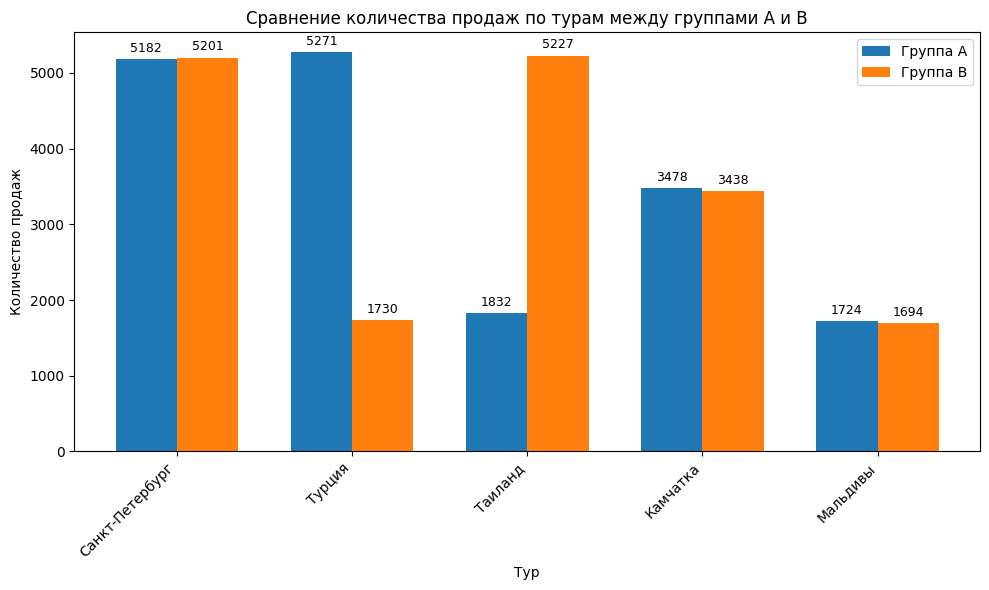

In [9]:
# 2.3. Сравнение по покупательской способности для каждого тура
# Создаем сводную таблицу: количество покупок по группе и цене тура (только где purchase=1)
purchase_data = data[data['purchase'] == 1]
pivot_table = purchase_data.pivot_table(
    index='price',
    columns='group',
    values='purchase',
    aggfunc='count',
    fill_value=0
).reset_index()

# Добавим названия туров для наглядности
tour_prices = {
    100000: 'Таиланд',
    60000: 'Турция',
    200000: 'Мальдивы',
    10000: 'Санкт-Петербург',
    150000: 'Камчатка'
}
pivot_table['tour'] = pivot_table['price'].map(tour_prices)
pivot_table = pivot_table[['tour', 'price', 'A', 'B']]
print('Количество продаж по турам и по группам:')
display(pivot_table)

# Визуализация
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(pivot_table))

bars_a = ax.bar(x - bar_width/2, pivot_table['A'], bar_width, label='Группа A')
bars_b = ax.bar(x + bar_width/2, pivot_table['B'], bar_width, label='Группа B')

ax.set_xlabel('Тур')
ax.set_ylabel('Количество продаж')
ax.set_title('Сравнение количества продаж по турам между группами A и B')
ax.set_xticks(x)
ax.set_xticklabels(pivot_table['tour'], rotation=45, ha='right')
ax.legend()

# Добавление подписей
for bars in [bars_a, bars_b]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)
            
plt.tight_layout()
plt.show()

### Выводы по покупательской способности:

- Для туров: Санкт-Петербург, Камчатка и Мальдивы количество продаж для групп A и B примерно одинаковые

- Для туров в Турцию (**60000 руб.**) у группы А больше продаж чем у группы B на **3541 шт.**

- Для туров в Таиланд (**100000 руб.**) у группы В больше продаж чем у группы А на **3395 шт.**

- Это может объяснять разницу в среднем чеке между группами.

## Шаг 3: Анализ стабилизации метрик


In [10]:
# 3.1. Группировка по дате и группе, расчет ежедневных показателей
daily_data = data.groupby(['date', 'group']).agg(
    daily_visits=('user_id', 'count'),
    daily_purchases=('purchase', 'sum'),
    daily_revenue=('price', 'sum')
).reset_index()

daily_data['daily_conversion'] = daily_data['daily_purchases']/daily_data['daily_visits']
daily_data['daily_avg_bill'] = daily_data['daily_revenue']/daily_data['daily_purchases']

print('Ежедневные показатели (первые 10 строк):')
display(daily_data.head(10))

Ежедневные показатели (первые 10 строк):


,date,group,daily_visits,daily_purchases,daily_revenue,daily_conversion,daily_avg_bill
0,2021-01-02,A,2854,359,29410000,0.125788,81922.005571
1,2021-01-02,B,2861,345,29660000,0.120587,85971.014493
2,2021-01-03,A,6596,748,62000000,0.113402,82887.700535
3,2021-01-03,B,6619,754,65960000,0.113914,87480.106101
4,2021-01-04,A,6566,799,64250000,0.121687,80413.016270
5,2021-01-04,B,6536,764,68030000,0.116891,89044.502618
6,2021-01-05,A,6433,790,64550000,0.122804,81708.860759
7,2021-01-05,B,6511,749,63550000,0.115036,84846.461949
8,2021-01-06,A,6606,764,63410000,0.115652,82997.382199
9,2021-01-06,B,6751,838,75020000,0.124130,89522.673031


In [11]:
# 3.2. Расчет кумулятивных показателей
daily_data = daily_data.sort_values(['group', 'date'])

for group in ['A', 'B']:
    group_mask = daily_data['group'] == group
    daily_data.loc[group_mask, 'cum_visits'] = daily_data.loc[group_mask, 'daily_visits'].cumsum()
    daily_data.loc[group_mask, 'cum_purchases'] = daily_data.loc[group_mask, 'daily_purchases'].cumsum()
    daily_data.loc[group_mask, 'cum_revenue'] = daily_data.loc[group_mask, 'daily_revenue'].cumsum()

daily_data['cum_conversion'] = daily_data['cum_purchases'] / daily_data['cum_visits']
daily_data['cum_avg_bill'] = daily_data['cum_revenue'] / daily_data['cum_purchases']

display(daily_data.head())

,date,group,daily_visits,daily_purchases,daily_revenue,daily_conversion,daily_avg_bill,cum_visits,cum_purchases,cum_revenue,cum_conversion,cum_avg_bill
0,2021-01-02,A,2854,359,29410000,0.125788,81922.005571,2854.0,359.0,29410000.0,0.125788,81922.005571
2,2021-01-03,A,6596,748,62000000,0.113402,82887.700535,9450.0,1107.0,91410000.0,0.117143,82574.525745
4,2021-01-04,A,6566,799,64250000,0.121687,80413.016270,16016.0,1906.0,155660000.0,0.119006,81668.415530
6,2021-01-05,A,6433,790,64550000,0.122804,81708.860759,22449.0,2696.0,220210000.0,0.120094,81680.267062
8,2021-01-06,A,6606,764,63410000,0.115652,82997.382199,29055.0,3460.0,283620000.0,0.119084,81971.098266


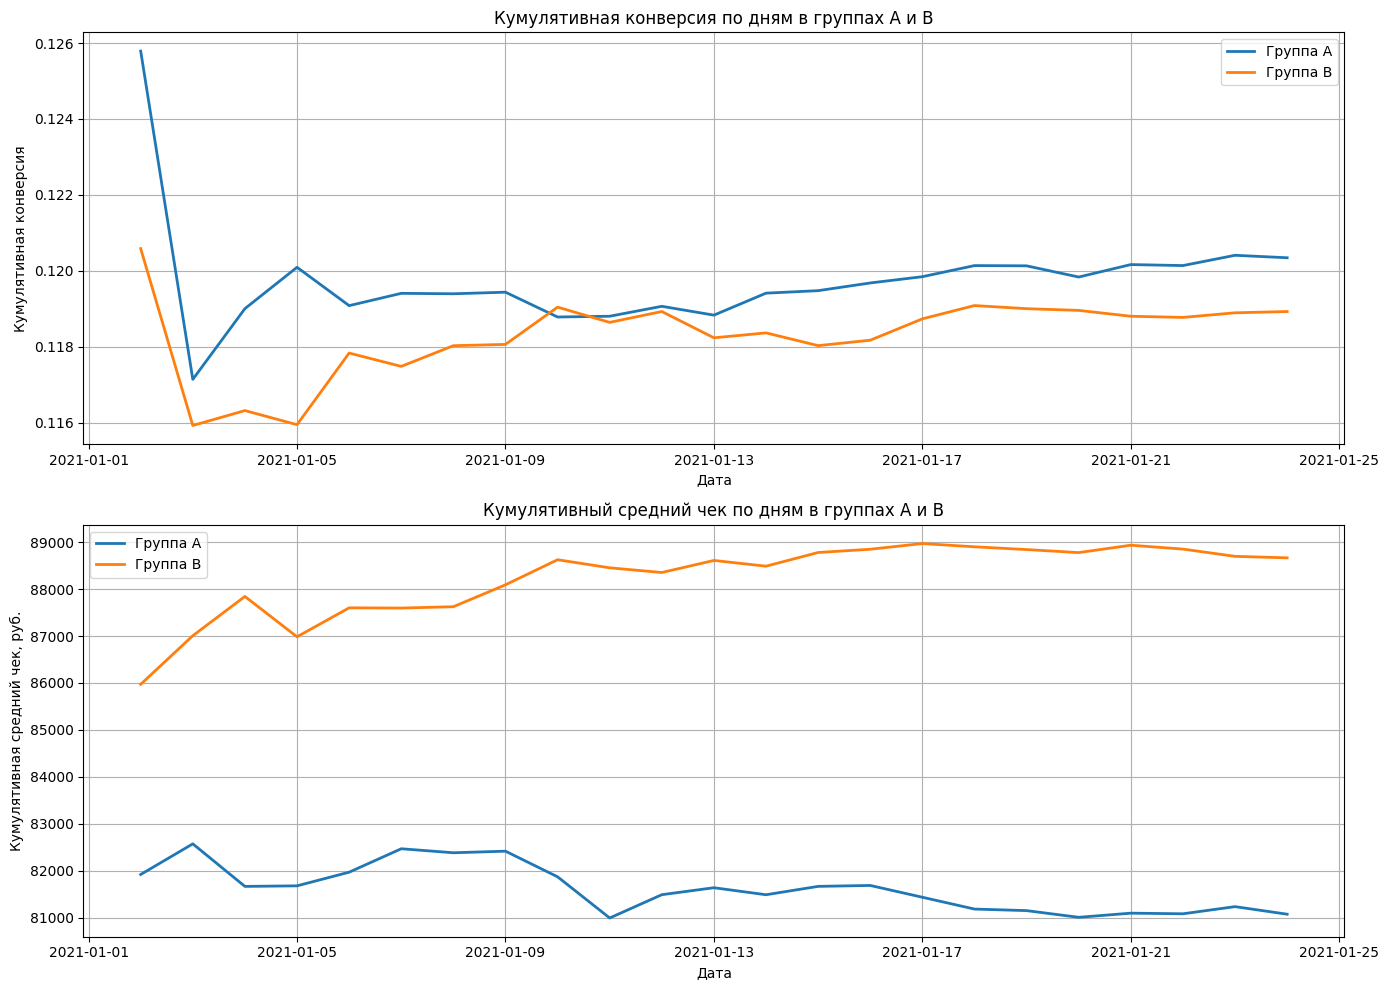

In [12]:
# 3.3. Построение кумулятивных графиков
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# График кумулятивной конверсии
for group in ['A', 'B']:
    group_data = daily_data[daily_data['group'] == group]
    axes[0].plot(group_data['date'], group_data['cum_conversion'], label=f'Группа {group}', linewidth=2)
    
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Кумулятивная конверсия')
axes[0].set_title('Кумулятивная конверсия по дням в группах A и B')
axes[0].legend()
axes[0].grid(True)

# График кумулятивного среднего чека
for group in ['A', 'B']:
    group_data = daily_data[daily_data['group'] == group]
    axes[1].plot(group_data['date'], group_data['cum_avg_bill'], label=f'Группа {group}', linewidth=2)
    
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Кумулятивная средний чек, руб.')
axes[1].set_title('Кумулятивный средний чек по дням в группах A и B')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Выводы по стабилизации метрик:

- Стабилизация: Кумулятивные графики конверсии и среднего чека выходят на "плато" в последние дни теста. Это означает, что метрики стабилизировались, и добавление новых данных вряд ли существенно изменит результаты.

- Завершенность теста: На основе визуального анализа можно сделать вывод, что A/B-тест можно считать завершенным. Продолжение теста не даст новой информации для принятия решения.

- Соотношение групп: Кумулятивная конверсия группы А после стабилизации метрик немного превышает данный показатель в группе B. Кумулятивный средний чек в группе B выше чем в группе A.

## Шаг 4: Статистический анализ результатов
### 4.1. Проверка статистической значимости различий в конверсии

Формулировка гипотез для конверсии:
- **H0: Конверсия в группе A равна конверсии в группе B. (p_A = p_B)**

- **H1: Конверсия в группе A НЕ равна конверсии в группе B. (p_A != p_B) - двусторонний тест**

In [13]:
# Подготовка данных для теста
visits_a = group_stats.loc[group_stats['group'] == 'A', 'visits'].values[0]
purchases_a = group_stats.loc[group_stats['group'] == 'A', 'purchases'].values[0]

visits_b = group_stats.loc[group_stats['group'] == 'B', 'visits'].values[0]
purchases_b = group_stats.loc[group_stats['group'] == 'B', 'purchases'].values[0]

print(f'Группа А: {purchases_a} покупок из {visits_a} визитов')
print(f'Группа B: {purchases_b} покупок из {visits_b} визитов')

# Z-тест для пропорций (двухвыборочный)
count = [purchases_a, purchases_b]
nobs = [visits_a, visits_b]
z_stat, p_value = proportions_ztest(count=count, nobs=nobs, alternative='two-sided')

print(f'\np-value: {p_value:.4f}')

alpha = 0.05
if p_value < alpha:
    print('p-value ниже уровня значимости. Отвергаем нулевую гипотезу.')
else:
    print('p-value больше либо равно уровню значимости. У нас нет оснований отвергнуть нулевую гипотезу.')

Группа А: 17487 покупок из 145307 визитов
Группа B: 17290 покупок из 145381 визитов

p-value: 0.2394
p-value больше либо равно уровню значимости. У нас нет оснований отвергнуть нулевую гипотезу.


### 4.2. Проверка статистической значимости различий в среднем чеке

Формулировка гипотез для среднего чека:

- **H0: Средний чек в группе A равен среднему чеку в группе B. (μ_A = μ_B)**

- **H1: Средний чек в группе A НЕ равен среднему чеку в группе B. (μ_A != μ_
B)**

Для сравнения средних используем t-тест (независимые выборки).
Перед этим проверим распределение цен покупок на нормальность (для каждой группы отдельно).
Это важно, так как t-тест чувствителен к нормальности данных.

In [14]:
price_a = data[(data['group'] == 'A') & (data['purchase'] == 1)]['price']
price_b = data[(data['group'] == 'B') & (data['purchase'] == 1)]['price']

print(f"Группа A: {len(price_a)} покупок. Группа B: {len(price_b)} покупок.")

Группа A: 17487 покупок. Группа B: 17290 покупок.


### Выборки достаточно большие, тест на нормальность не требуется

In [15]:
stat_a, p_a = stats.shapiro(price_a)
stat_b, p_b = stats.shapiro(price_b)

# Проведем t-тест (предполагаем гомогенность дисперсий, проверять не будем для краткости)
t_stat, p_value_ttest = stats.ttest_ind(price_a, price_b, equal_var=True, nan_policy='omit')

print('Результаты t-теста для среднего чека:')
print(f'p-value: {p_value_ttest:.4f}\n')

if p_value_ttest < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('У нас нет оснований отвергнуть нулевую гипотезу')

Результаты t-теста для среднего чека:
p-value: 0.0000

Отвергаем нулевую гипотезу


### 4.3. Построение и интерпретация 95% доверительных интервалов

95% доверительные интервалы для конверсий:
Группа A: 0.1203 [0.1187, 0.1220]
Группа B: 0.1189 [0.1173, 0.1206]

Разница конверсий (B - A): -0.0014
95% доверительные для разницы конверсий: [-0.0038, 0.0009]

95% доверительные интервалы для средних чеков:
Группа A: 81076.23 руб. [80137.86, 82014.60]
Группа B: 88664.55 руб. [87728.24, 89600.85]


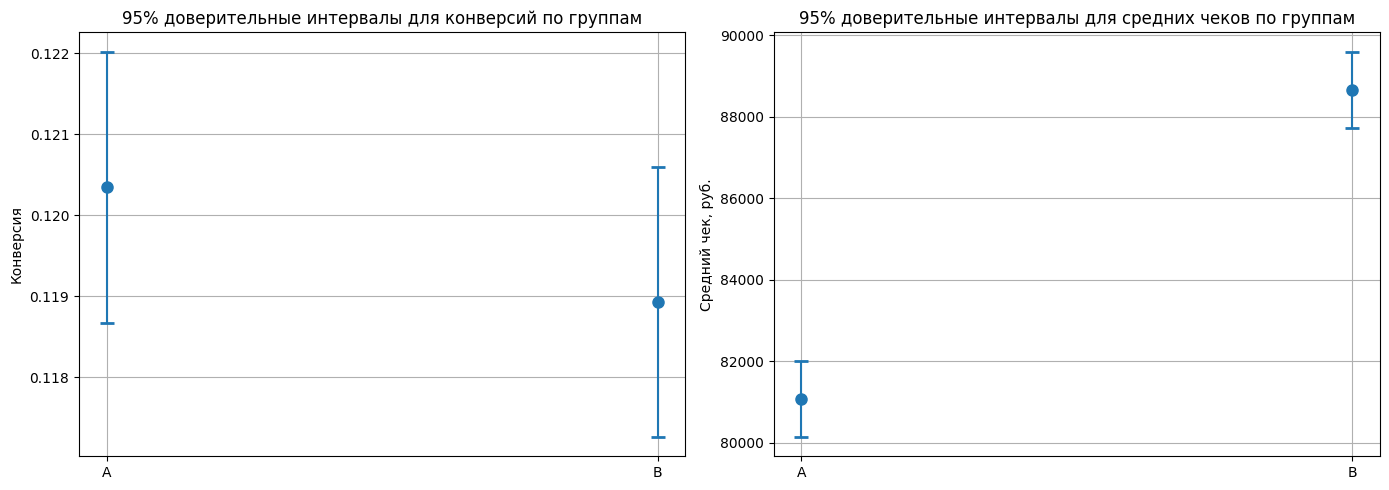

In [16]:
# Функция для расчета доверительного интервала для пропорции (конверсии)
def ci_proportion(purchase, visit, alpha=0.05):
    p = purchase/visit
    se = np.sqrt(p * (1 - p) / visit)
    z = stats.norm.ppf(1 - alpha/2)
    margin = z * se
    return p, p - margin, p + margin

# Функция для расчета доверительного интервала для среднего (среднего чека)
def ci_mean(sample, alpha=0.05):
    mean = np.mean(sample)
    se = stats.sem(sample, nan_policy='omit')
    h = se * stats.t.ppf(1 - alpha/2, len(sample)-1)
    return mean, mean - h, mean + h

# ДИ для конверсий
p_a, ci_low_a, ci_high_a = ci_proportion(purchases_a, visits_a)
p_b, ci_low_b, ci_high_b = ci_proportion(purchases_b, visits_b)

print('95% доверительные интервалы для конверсий:')
print(f'Группа A: {p_a:.4f} [{ci_low_a:.4f}, {ci_high_a:.4f}]')
print(f'Группа B: {p_b:.4f} [{ci_low_b:.4f}, {ci_high_b:.4f}]')

# ДИ для разницы конверсий
p_diff = p_b - p_a
se_diff = np.sqrt(p_a*(1-p_a)/visits_a + p_b*(1-p_b)/visits_b)
z = stats.norm.ppf(1 - 0.05/2)
ci_low_diff = p_diff - z * se_diff
ci_high_diff = p_diff + z * se_diff

print(f'\nРазница конверсий (B - A): {p_diff:.4f}')
print(f'95% доверительные для разницы конверсий: [{ci_low_diff:.4f}, {ci_high_diff:.4f}]')

# ДИ для разницы средних чеков
mean_a, ci_low_avg_a, ci_high_avg_a = ci_mean(price_a)
mean_b, ci_low_avg_b, ci_high_avg_b = ci_mean(price_b)

print('\n95% доверительные интервалы для средних чеков:')
print(f'Группа A: {mean_a:.2f} руб. [{ci_low_avg_a:.2f}, {ci_high_avg_a:.2f}]')
print(f'Группа B: {mean_b:.2f} руб. [{ci_low_avg_b:.2f}, {ci_high_avg_b:.2f}]')

# Визуализация ДИ для конверсий
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# График ДИ конверсий
ax1.errorbar(x=['A', 'B'], y=[p_a, p_b],
             yerr=[[p_a - ci_low_a, p_b - ci_low_b], [ci_high_a - p_a, ci_high_b - p_b]],
             fmt='o', capsize=5, capthick=2, markersize=8)
ax1.set_ylabel('Конверсия')
ax1.set_title('95% доверительные интервалы для конверсий по группам')
ax1.grid(True)

# График ДИ средних чеков
ax2.errorbar(x=['A', 'B'], y=[mean_a, mean_b],
             yerr=[[mean_a - ci_low_avg_a, mean_b - ci_low_avg_b],
                   [ci_high_avg_a - mean_a, ci_high_avg_b - mean_b]],
             fmt='o', capsize=5, capthick=2, markersize=8)
ax2.set_ylabel('Средний чек, руб.')
ax2.set_title('95% доверительные интервалы для средних чеков по группам')
ax2.grid(True)

plt.tight_layout()
plt.show()

### Интерпретация доверительных интервалов:

**Для конверсий:**

- Доверительные интервалы групп A и B перекрываются (граница группы A **0.1187** ниже верхней границы группы B **0.1206**). Это визуально подтверждает отсутствие статистически значимой разницы.

- Доверительный интервал для разницы конверсий (B - A) содержит **ноль** (от **-0.0038** до **0.0009**). Это прямое указание на статистическую незначимость различия.

**Для средних чеков:**

- Доверительные интервалы для средних чеков групп A и B **не перекрываются** (верхняя граница группы А **82014.60** руб. значительно **ниже** нижней границы группы B **87728.24** руб.). Это говорит о статистически значимой разнице.

## Шаг 5: Общий вывод и рекомендации

### На основе проведенного анализа:

### 1. **По конверсии:**

- Статистический тест (Z-тест) показал, что разница в конверсии между группами НЕ является статистически значимой (p-value = 0.2394).

- Конверсия в группе A составила 12.03%, что незначительно выше конверсии в группе B (11.89%). Разница составляет всего 0.14 процентных пункта.

**Вывод: С точки зрения конверсии в покупку, оба варианта посадочной страницы работают одинаково эффективно. Статистически значимого преимущества ни один вариант не имеет.**

### 2. **По среднему чеку:**

- Статистический тест (t-тест) показал, что разница в среднем чеке между группами является статистически значимой (p-value ≈ 0.0000).

- Средний чек в группе B составил 88 665 руб., что статистически значимо выше среднего чека в группе A (81 076 руб.). Разница составляет почти 7 600 рублей.

    **Анализ по турам показал ключевую причину этого:**

    - В группе B резко выросли продажи дорогого тура в Таиланд (100 000 руб.): 5 227 покупок против 1 832 в группе A.

    - В группе A, напротив, резко выше продажи более дешевой Турции (60 000 руб.): 5 271 покупка против 1 730 в группе B.

    - По остальным турам (Санкт-Петербург, Камчатка, Мальдивы) продажи практически равны.

**Вывод: Вариант посадочной страницы B существенно более эффективен для увеличения среднего размера покупки. Он мотивирует пользователей выбирать более дорогие туры.**

### 3. **Итоговая рекомендация для бизнеса:**

>**Вариант посадочной страницы B является более предпочтительным.**

**Обоснование:**

- Хотя конверсии статистически не различаются, средний чек в группе B значительно выше.

- Рассчитаем ключевой бизнес-показатель — среднюю выручку с одного посетителя (RPV):

    - RPV_A = Конверсия_A * Средний чек_A = 0.1203 * 81 076 ≈ **9 757** руб. с посетителя.

    - RPV_B = Конверсия_B * Средний чек_B = 0.1189 * 88 665 ≈ **10 543** руб. с посетителя.

- Вариант B приносит на **786** руб. больше с каждого посетителя сайта. Это прямая финансовая выгода.

**Интерпретация доверительных интервалов:**

- Для конверсий: Доверительные интервалы [0.1187, 0.1220] для A и [0.1173, 0.1206] для B сильно **перекрываются**. ДИ для разницы [-0.0038, 0.0009] **включает ноль**. Это еще одно подтверждение **отсутствия** статистически значимой разницы.

- Для средних чеков: Доверительные интервалы [80138, 82015] для A и [87728, 89601] для B **НЕ ПЕРЕКРЫВАЮТСЯ**. Это наглядное доказательство статистически **значимой** разницы.

**Качественный вывод: Дизайн страницы B, по-видимому, лучше презентует или продвигает премиальные направления (в частности, Таиланд), смещая предпочтения пользователей в сторону более дорогих покупок, без снижения общей вероятности совершить покупку.**

### **Рекомендация:** Внедрить вариант посадочной страницы B в качестве основного, так как он приводит к статистически значимому увеличению среднего чека и, как следствие, общей выручки компании.